# 2: Power Outage Identification: Preprocessing and Word2Vec Model

### Contents:
- [Imports](#Imports)
- [Preprocessing](#Preprocessing)
- [Word2Vec Model](#Word2Vec-Model)
  * [Train Model](#Train-Model)
- [t-SNE Model Exploration](#t-SNE-Model-Exploration)  
  * [Visualization](#Visualization)
  * [Exporting Visual](#Exporting-Visual)
- [Evaluation](#Evaluation)  

## Imports

In [1]:
# Importing packages
from __future__ import absolute_import, division, print_function
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
from nltk.corpus import stopwords

#importing warning to turn off future warnings
import warnings
warnings.simplefilter(action='ignore')

/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


## Preprocessing

Based on what we learned when reviewing our data in EDA, we set out to prepare the text for modeling by lower casing all words and removing punctuation and stopwords. We also removed complete url strings before tokenizing to make sure we captured all the url pieces, especially link shorteners. We printed out a sample tweet as it was altered to confirm that each step processed correctly.

In [2]:
#reading in the data
all_tweets_df = pd.read_csv('./datasets/combined_data.csv')
all_tweets_df.drop(columns='Unnamed: 0', inplace = True)
print(f'Shape of DataFrame: {all_tweets_df.shape}')
all_tweets_df.head()

Shape of DataFrame: (5684, 9)


id                                               text  \
0  9.732586e+17  Power outage in the area causing delays. treat...   
1  1.036794e+18  Aaaaaand the power is out. (@ La Casa De Los K...   
2  1.035702e+18  Lack of #fridaynightlights here...  #powerouta...   
3  1.021838e+18  Multiple signals on flash due to a power outag...   
4  6.906223e+17  ATXoutage update: outage was caused by a hit p...   

             timestamp             user location   datestamp  \
0  2018-03-12 18:04:57  TotalTrafficAUS   Austin  2018-03-12   
1   2018-09-04 1:52:41         Daragaya   Austin  2018-09-04   
2   2018-09-01 1:33:58      MartinGarza   Austin  2018-09-01   
3  2018-07-24 19:23:17  TotalTrafficAUS   Austin  2018-07-24   
4  2016-01-22 19:49:32        Austin_CP   Austin  2016-01-22   

           date_place                combined_text  \
0  2018-03-12, Austin            dry, hot, cold ||   
1  2018-09-04, Austin        downpour, hot, hot ||   
2  2018-09-01, Austin       dry, scorching, hot ||   
3  2018-07-24, Austin  downpour, scorching, hot ||   
4  2016-01-22, Austin      downpour, warm, cold ||   

                                            all_text  
0  Power outage in the area causing delays. treat...  
1  Aaaaaand the power is out. (@ La Casa De Los K...  
2  Lack of #fridaynightlights here...  #powerouta...  
3  Multiple signals on flash due to a power outag...  
4  ATXoutage update: outage was caused by a hit p...

In [3]:
# create series just containing the text column
all_tweets = all_tweets_df['all_text']
print(f'Number of tweets: {len(all_tweets)}')

Number of tweets: 5684


In [4]:
# setting stopwords
stop_words = stopwords.words('english')

In [5]:
# Function to clean up tweets (removing urls, non-alphabetical characters)
def tweets_to_tweetlist(raw):
    clean = re.sub(r"[^a-zA-Z ]", "", raw)
    clean = re.sub(r"http.*?\b","",clean)
    clean = re.sub(r"pictwitter.*?\b","",clean)
    clean = re.sub(r"www.*?\b","",clean)
    clean = re.sub(r'instagramcom.*?\b','',clean)
    return clean

In [6]:
# Iterate through all_tweets, clean tweets and add to tweet_list
tweet_list = []
for tweet in all_tweets:
    tweet_list.append(tweets_to_tweetlist(tweet))
len(tweet_list)

5684

In [7]:
# Iterate through tweet_list convert to lowercase and tokenize each tweet
tokenized_tweet_list = [tweet.lower().split(' ') for tweet in tweet_list]   

In [8]:
# Remove stop words from tweets
# final_tweet_list is the version of our tweet list we will use from here on
final_tweet_list = []
for tweet in tokenized_tweet_list:
    word_list = []
    for word in tweet:
        if (word not in stop_words) & (word != ''):
            word_list.append(word)
    final_tweet_list.append(word_list)

In [9]:
#Seeing how many tweets we'll be working with
len(final_tweet_list)

5684

In [10]:
# Count number of words in tweets list (all tweets)
token_count = sum([len(tweet) for tweet in final_tweet_list])
print(f"The tweet list contains {token_count} tokens")

The tweet list contains 68989 tokens


In [11]:
# Compare different versions of tweets and see how they changed
def compare_tweets(n):    
    print(all_tweets[n]) # original version of nth tweet
    print()
    print(tweet_list[n]) # cleaned version of nth tweet
    print()
    print(tokenized_tweet_list[n]) # tokenized version of nth tweet
    print()
    print(final_tweet_list[n]) # tokenized version of nth tweet (stopwords removed)

In [12]:
#calling the first tweet 
compare_tweets(0)

Power outage in the area causing delays. treat as all way stop. in #Austin on Parmer Ln at Dessau Rd #ATXtraffic http://bit.ly/10BGKax , dry, hot, cold ||

Power outage in the area causing delays treat as all way stop in Austin on Parmer Ln at Dessau Rd ATXtraffic  dry hot cold 

['power', 'outage', 'in', 'the', 'area', 'causing', 'delays', 'treat', 'as', 'all', 'way', 'stop', 'in', 'austin', 'on', 'parmer', 'ln', 'at', 'dessau', 'rd', 'atxtraffic', '', 'dry', 'hot', 'cold', '']

['power', 'outage', 'area', 'causing', 'delays', 'treat', 'way', 'stop', 'austin', 'parmer', 'ln', 'dessau', 'rd', 'atxtraffic', 'dry', 'hot', 'cold']


## Word2Vec Model

We chose to use Word2Vec to model our data because of the way it focuses on the relationship of words and gives weight to that value. It maps the words from our dataset into a high dimensional space using a neural network. From that, we are able to train the model so that it can “learn” the conceptual relationship between words.  We wanted to use Word2Vec because it brings context of word choices into play, which will give us a better understanding of the group of words used in a tweet to talk about a power outage.  

In [13]:
# Instantiate Word2Vec model
tweets2vec = w2v.Word2Vec(
    sg = 1, # skip-gram train algo
    seed = 42, # Random Number Generator to make results repeatable
    workers = multiprocessing.cpu_count(), # number of threads
    size = 300, # Dimensionality of the hidden layer
    min_count = 3, # how many times the word has to appear to be kept in the vocab.
    window = 7, # size of the window to train words
    sample = 1e-5 # downsampling setting for frequent words
)

In [14]:
# Build tweets2vec vocabulary, haven't trained it yet, just loading it into memory
tweets2vec.build_vocab(final_tweet_list)

In [15]:
# how long is our tweets2vec vocabulary?
print("Tweets2Vec vocabulary length:", len(tweets2vec.wv.vocab))

Tweets2Vec vocabulary length: 2471


### Train Model

We trained our model on our tweet list so that it could "learn" the relationship of the words in the dataset.

In [16]:
# Train tweets2vec model on final_tweet_list
tweets2vec.train(final_tweet_list, total_examples=tweets2vec.corpus_count, epochs=tweets2vec.epochs)

(40182, 344945)

In [17]:
# Create directory to store our trained tweets2vec model in
if not os.path.exists("./datasets/training_model"):
    os.makedirs("./datasets/training_model")

In [18]:
# Save our trained tweets2vec model in the trained folder
tweets2vec.wv.save("./datasets/training_model/tweets2vec.w2v")

## t-SNE Model Exploration

While machines have no problem understanding high dimensional space, we needed to convert it back to two-dimensional space in order to examine and understand it. We used a t-SNE model for dimensionality reduction. 

Interpretability of t-SNE plots is not really intuitive right away. However what the plot is suppose to reveal is the relationships these words have to one another. Similar words or words that have a high probability appearing together will be close together in this plot while others without a positive relationship will appear further away. In the future we should consider running multiple versions of a t-SNE plot as each run, each parameter change, and each training session of the model can create a different plot with different interpretations. 

In [19]:
# reading in the trained data to explore it
tweets2vec = tweets2vec.wv.load("./datasets/training_model/tweets2vec.w2v")

In [20]:
# this is a word vector in 300 dimensional word space. We need to take it down a bit using TSNE
# That is t-distributed Stochastic Neighbor Embedding. Essentially it is a tool to visualize high-dimensional data.
# Takes a 300 dim vector and squashes it into 2 and derives coordinates from them.
# Here we are instantiating the t-SNE plot and establishing the parameters. 
tsne = sklearn.manifold.TSNE(n_components = 2, random_state = 42, perplexity= 70,learning_rate = 150,verbose =1,n_iter=5000)

In [21]:
# right now the tweets and their words are vectorized, converted into numbers. We need to convert them to word embeddings
# to start plotting them on the map in 2D.
all_word_vectors_matrix = tweets2vec.wv.syn0

In [22]:
# Training it will take some time...
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 2471 samples in 0.019s...
[t-SNE] Computed neighbors for 2471 samples in 3.377s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2471
[t-SNE] Computed conditional probabilities for sample 2000 / 2471
[t-SNE] Computed conditional probabilities for sample 2471 / 2471
[t-SNE] Mean sigma: 0.003653
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.176208
[t-SNE] KL divergence after 1550 iterations: 3.011796


In [23]:
#creating a dataframe of the t-SNE coordinates
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[tweets2vec.vocab[word].index])
            for word in tweets2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [24]:
# Edited code from Boom Devahastin Na Ayudhya
# Define vectorization function
def vectorize_corpus(keyword_list):    
    
    # Instantiate counter for number of words in keyword_list that exists
    n_words = 0
    
    # Create template for cumulative corpus vector sum
    corpus_vec_sum = np.zeros((1,300))                 
    
    # Scan through each word in list
    for word in keyword_list:
        if word in tweets2vec.vocab:                    
            word_vec = tweets2vec.word_vec(word)        
            n_words +=1                                
            corpus_vec_sum = corpus_vec_sum + word_vec 

    # Compute average vector by taking cumulative vector sum and dividing it by number of words traced
    corpus_avg_vec = corpus_vec_sum/n_words
    
    # Squeeze this N-dimensional nested array object into a 1-D array to streamline future processing
    corpus_avg_vec = np.squeeze(corpus_avg_vec)
    
    return(corpus_avg_vec)

In [25]:
#defining cosine similarity function
def cos_sim(vector_1, vector_2):
    dp = np.dot(vector_1, vector_2)
    magnitude_v1 = np.sqrt(np.dot(vector_1,vector_1))
    magnitude_v2 = np.sqrt(np.dot(vector_2,vector_2))
    return(dp/(magnitude_v1*magnitude_v2))

To classify our tweets, we set up a list of positive and negative words for them to be compared to, using a cosine similarity score. The keyword lists were developed by exploring the dataset and extracting words that related more to power outages versus words that related to outages that were not power related. These included telecommunications outages as well as websites doing down such as Netflix or Facebook.

We edited this list as we fine tuned our model, watching for any misclassification word patterns.

In [26]:
#creating our pos/neg keyword lists 

# List of words for legitimate outages
power_out = ['generators','flooding','austinenergy','santaclarapower','grid', 'massive',
           'failure','generator','darkness','utoutage','powers','txuenergy','thunderstorms',
           'major', 'serious', 'surge', 'storm','storms','transformer','power','windstorm',
           'substation', 'alert', 'electrical', 'lights','thunderstorm','snake',
           'lightning','electricity','poweroutage','delays','atxoutage','nopower','lightsout',
           'candlelight','candle','candles','comed','coned','conedison','cnpalerts']

# List of words for non-legitimate outages (such as internet, Netflix, Facebook, or other service outages)
not_out = ['lines','whatsapp','aws','airworldwide','broadband','askspectrum','amtrack','dropbox',
               'twitter','skype','instagram','insta','espnfantasy','directv','netflix',
               'hulu', 'warner','microsoft','cable','tw','service','time',
               'twc','itunes','apple','attcares','attcustomercare','att','phones',
               'youtube','yt','facebook','centurylink','connectivity','network',
               'gmail','uverse', 'verizon', 'tmobile', 'phone', 'sprintcare',
               'sprint','wifi','internet', 'wireless', 'comcast','rcn','grandecom',
               'comcastcares','rcnconnects','playstation','sony','xfinity',
               'ig','fb','twchelp','nationwide','google','googlefiber','frontier','frontiercorp']

In [27]:
#vectorizing the keyword lists
power_out_vec = vectorize_corpus(power_out)
not_out_vec = vectorize_corpus(not_out)

In [28]:
#scoring words against our keywords
points['power_out_cs'] = [cos_sim(tweets2vec.word_vec(word),power_out_vec) for word in points['word']]
points['not_out_cs'] = [cos_sim(tweets2vec.word_vec(word),not_out_vec) for word in points['word']]
points['power_out_label'] = np.where(points['power_out_cs'] >= points['not_out_cs'],'power_out','not_out')
points.head()

word         x         y  power_out_cs  not_out_cs power_out_label
0    power  1.200713 -4.588473      0.897068    0.867869       power_out
1   outage  1.199586 -4.588007      0.861180    0.851777       power_out
2     area  1.121574 -4.150607      0.628891    0.651128         not_out
3  causing -1.989224 -0.225583      0.149681    0.145249       power_out
4   delays  1.506836 -3.556285      0.537542    0.543483         not_out

In [29]:
#getting the counts for each label
points['power_out_label'].value_counts()

power_out    1413
not_out      1058
Name: power_out_label, dtype: int64

In [30]:
#sorting to see what words appear up top for legitimate power outages
points[points['power_out_label'] == 'power_out'].sort_values(by = 'power_out_cs',ascending = False).head(10)

word         x         y  power_out_cs  not_out_cs power_out_label
0         power  1.200713 -4.588473      0.897068    0.867869       power_out
40         warm  1.199927 -4.586278      0.884201    0.846958       power_out
13          hot  1.199167 -4.583988      0.867573    0.841887       power_out
1        outage  1.199586 -4.588007      0.861180    0.851777       power_out
12          dry  1.197251 -4.573006      0.842048    0.812476       power_out
14         cold  1.188070 -4.521953      0.810343    0.771078       power_out
61   torrential  1.173988 -4.452332      0.799717    0.758742       power_out
237    freezing  1.173763 -4.465154      0.787939    0.744180       power_out
53      without  1.172501 -4.438139      0.771071    0.734330       power_out
25    scorching  1.160064 -4.383176      0.736210    0.724522       power_out

In [31]:
#seeing what the top are for not a legitamate power outage
points[points['power_out_label'] == 'not_out'].sort_values(by = 'not_out_cs',ascending = False).head(10)

word         x         y  power_out_cs  not_out_cs power_out_label
19   downpour  1.129496 -4.322610      0.686698    0.690761         not_out
82   internet  1.130426 -4.136052      0.640889    0.667051         not_out
2        area  1.121574 -4.150607      0.628891    0.651128         not_out
99       lost  0.891661 -3.828778      0.580115    0.616503         not_out
422   several  1.048320 -4.075009      0.590947    0.603122         not_out
30         us  1.133970 -3.879995      0.551897    0.579369         not_out
161      hour  1.068431 -3.791443      0.536414    0.573560         not_out
4      delays  1.506836 -3.556285      0.537542    0.543483         not_out
424      last  0.988075 -3.857256      0.539448    0.541345         not_out
134       one  0.787269 -3.885129      0.509799    0.536305         not_out

In [32]:
#checking out what words are most similar to the word "power"
tweets2vec.most_similar("power", topn=10)

[('hot', 0.916190505027771),
 ('outage', 0.9161201119422913),
 ('warm', 0.9149012565612793),
 ('dry', 0.8738179802894592),
 ('cold', 0.8459444046020508),
 ('torrential', 0.8262581825256348),
 ('freezing', 0.8176238536834717),
 ('without', 0.7819161415100098),
 ('scorching', 0.7752233743667603),
 ('downpour', 0.7506681680679321)]

In [33]:
#checking out what words are most similar to the word "outage"
tweets2vec.most_similar("outage")

[('power', 0.9161201119422913),
 ('warm', 0.9024008512496948),
 ('hot', 0.8913711309432983),
 ('dry', 0.8729724884033203),
 ('cold', 0.8407845497131348),
 ('torrential', 0.8116342425346375),
 ('freezing', 0.7903087139129639),
 ('scorching', 0.789858877658844),
 ('without', 0.7773873805999756),
 ('downpour', 0.7531493902206421)]

In [34]:
#taking a look at each tweet with both scores so we can review what word groups were used to create the score
#this is helpful for fine tuning the model
for tweet in final_tweet_list:
    print(tweet)
    tweet_avg_vec = vectorize_corpus(tweet)
    print(f'Power Out CS: {cos_sim(tweet_avg_vec,power_out_vec)}')
    print(f'Not Out CS: {cos_sim(tweet_avg_vec,not_out_vec)}')

['power', 'outage', 'area', 'causing', 'delays', 'treat', 'way', 'stop', 'austin', 'parmer', 'ln', 'dessau', 'rd', 'atxtraffic', 'dry', 'hot', 'cold']
Power Out CS: 0.901219909565264
Not Out CS: 0.8711103686777614
['aaaaaand', 'power', 'la', 'casa', 'de', 'los', 'kellers', 'austin', 'tx', 'downpour', 'hot', 'hot']
Power Out CS: 0.8824563339899641
Not Out CS: 0.8522788112791324
['lack', 'fridaynightlights', 'poweroutage', 'tpd', 'dripping', 'springs', 'high', 'school', 'dry', 'scorching', 'hot']
Power Out CS: 0.8627477071386472
Not Out CS: 0.8271862358555823
['multiple', 'signals', 'flash', 'due', 'power', 'outage', 'us', 'braker', 'ln', 'atxtraffic', 'downpour', 'scorching', 'hot']
Power Out CS: 0.8961652000044951
Not Out CS: 0.8780702246448167
['atxoutage', 'update', 'outage', 'caused', 'hit', 'power', 'cable', 'th', 'henderson', 'customers', 'restored', 'crews', 'downpour', 'warm', 'cold']
Power Out CS: 0.8986157478756506
Not Out CS: 0.8748008001891198
['power', 'customers', 'followi

Not Out CS: 0.8638018915302289
['power', 'restored', 'austin', 'energy', 'customers', 'outage', 'update', 'power', 'restored', 'drizzle', 'cold', 'freezing']
Power Out CS: 0.9032405027936833
Not Out CS: 0.8689764792385049
['kxannews', 'power', 'outage', 'great', 'hills', 'atxtraffic', 'drizzle', 'cold', 'freezing']
Power Out CS: 0.8936770267005981
Not Out CS: 0.8687336222442889
['hope', 'dont', 'unexpected', 'power', 'outage', 'issues', 'hope', 'backed', 'onlytimewilltell', 'gypsy', 'downpour', 'warm', 'cold']
Power Out CS: 0.8909496466164252
Not Out CS: 0.8618588332291353
['power', 'tho', 'downpour', 'warm', 'cold']
Power Out CS: 0.9032085183752422
Not Out CS: 0.8666667168701733
['huge', 'part', 'west', 'campus', 'lost', 'electricity', 'shall', 'look', 'back', 'laugh', 'right', 'im', 'pretty', 'fucking', 'pissed', 'lol', 'downpour', 'cold', 'cold']
Power Out CS: 0.8518270328815755
Not Out CS: 0.8314225813505111
['know', 'power', 'area', 'aint', 'need', 'start', 'lighting', 'fireworks'

Power Out CS: 0.8916620423718645
Not Out CS: 0.8624105400724411
['trapped', 'train', 'power', 'probably', 'going', 'get', 'ebola', 'torrential', 'hot', 'warm']
Power Out CS: 0.897262943024016
Not Out CS: 0.8674976698361277
['ebola', 'comin', 'wipe', 'nobeeetch', 'power', 'storm', 'coming', 'phone', 'last', 'tweet', 'fuck', 'yall', 'except', 'chicken', 'torrential', 'hot', 'warm']
Power Out CS: 0.8992254823638289
Not Out CS: 0.8631003327610107
['rcnconnects', 'outage', 'chicago', 'online', 'light', 'modem', 'went', 'min', 'ago', 'stayed', 'restart', 'torrential', 'hot', 'warm']
Power Out CS: 0.8869704173998109
Not Out CS: 0.8633062552963293
['totuspower', 'bringing', 'power', 'classrooms', 'without', 'power', 'using', 'lithium', 'batteries', 'cars', 'partnership', 'bmw', 'bethechange', 'bmw', 'drizzle', 'hot', 'warm']
Power Out CS: 0.90507084913802
Not Out CS: 0.8763779432201645
['simeon', 'power', 'dry', 'hot', 'cold']
Power Out CS: 0.9057556128630355
Not Out CS: 0.8737540548794938
['c

Not Out CS: 0.866805902473633
['came', 'home', 'power', 'outage', 'bobs', 'house', 'horrors', 'columbus', 'oh', 'dry', 'hot', 'warm']
Power Out CS: 0.9057867171657699
Not Out CS: 0.8804188832694888
['still', 'without', 'power', 'franklin', 'co', 'aep', 'ohio', 'says', 'everyone', 'shold', 'power', 'restored', 'torrential', 'hot', 'warm']
Power Out CS: 0.9055613499986536
Not Out CS: 0.8736810342813381
['right', 'aep', 'customers', 'without', 'power', 'storm', 'rolls', 'central', 'ohio', 'tv', 'tv', 'downpour', 'scorching', 'warm']
Power Out CS: 0.8874377526507248
Not Out CS: 0.8464385745340984
['school', 'delay', 'grandview', 'heights', 'schools', 'hour', 'delay', 'due', 'power', 'outage', 'wsyx', 'torrential', 'hot', 'hot']
Power Out CS: 0.9013339591180447
Not Out CS: 0.8650239175983773
['aep', 'ohio', 'reporting', 'almost', 'without', 'power', 'nbci', 'torrential', 'hot', 'hot']
Power Out CS: 0.8922904830972854
Not Out CS: 0.866763859367121
['aep', 'ohio', 'reports', 'customers', 'wit

Not Out CS: 0.872310349841241
['december', 'power', 'cinema', 'nolight', 'poweroutage', 'regal', 'macarthur', 'torrential', 'cold', 'freezing']
Power Out CS: 0.903583831033753
Not Out CS: 0.8584836777465863
['power', 'outage', 'tornado', 'damage', 'garland', 'ebwb', 'bobtown', 'rd', 'bass', 'pro', 'dr', 'dfwtraffic', 'torrential', 'warm', 'cold']
Power Out CS: 0.8960996547096917
Not Out CS: 0.8751969518749275
['brookhaven', 'college', 'reopens', 'power', 'outage', 'canceled', 'classes', 'monday', 'dry', 'cold', 'cold']
Power Out CS: 0.8838355994288256
Not Out CS: 0.8555432674719823
['brookhaven', 'college', 'reopens', 'power', 'outage', 'canceled', 'classes', 'monday', 'dry', 'cold', 'cold']
Power Out CS: 0.8838355994288256
Not Out CS: 0.8555432674719823
['powers', 'house', 'im', 'shopping', 'cybermonday', 'phone', 'tonight', 'theres', 'full', 'dry', 'cold', 'cold']
Power Out CS: 0.8567939997875025
Not Out CS: 0.8316813109629699
['brookhaven', 'college', 'reopen', 'tuesday', 'power', '

Power Out CS: 0.9091028332710571
Not Out CS: 0.8607409785740361
['yesterday', 'purchase', 'ton', 'candles', 'today', 'power', 'outage', 'across', 'arlington', 'hours', 'later', 'still', 'waiting', 'coincidence', 'maybe', 'life', 'torrential', 'hot', 'warm']
Power Out CS: 0.9023891270417208
Not Out CS: 0.8731744615870838
['power', 'outage', 'ebola', 'come', 'texas', 'torrential', 'hot', 'warm']
Power Out CS: 0.9090848125046364
Not Out CS: 0.8762501032742989
['nothing', 'like', 'power', 'outage', 'help', 'appreciate', 'much', 'light', 'pollution', 'normally', 'night', 'candletime', 'torrential', 'hot', 'warm']
Power Out CS: 0.9058442825813035
Not Out CS: 0.880366957840393
['power', 'food', 'open', 'devil', 'torrential', 'hot', 'warm']
Power Out CS: 0.9064824673237037
Not Out CS: 0.8631702634118751
['antonioavilahoe', 'still', 'remember', 'last', 'year', 'power', 'outagenimitzvikings', 'cheap', 'ass', 'torrential', 'hot', 'warm']
Power Out CS: 0.9035922187741912
Not Out CS: 0.871555989514

Power Out CS: 0.9130974087840059
Not Out CS: 0.8788166267163705
['vbryantttt', 'power', 'outmine', 'torrential', 'hot', 'warm']
Power Out CS: 0.9135379767397249
Not Out CS: 0.8794837772434246
['alishaadamss', 'power', 'righht', 'mines', 'torrential', 'hot', 'warm']
Power Out CS: 0.9101892182228424
Not Out CS: 0.8774616930100795
['power', 'hope', 'dteenergy', 'fixes', 'quickly', 'torrential', 'hot', 'warm']
Power Out CS: 0.9061890095886485
Not Out CS: 0.8678316579533144
['hoping', 'storm', 'blows', 'power', 'torrential', 'hot', 'warm']
Power Out CS: 0.9075989303215772
Not Out CS: 0.8739619609992706
['power', 'school', 'yes', 'torrential', 'hot', 'warm']
Power Out CS: 0.9075679461667144
Not Out CS: 0.8720195189640334
['next', 'localnews', 'noon', 'caused', 'outage', 'left', 'detroit', 'public', 'schools', 'dark', 'torrential', 'warm', 'cold']
Power Out CS: 0.8901694009274701
Not Out CS: 0.8532838749686691
['several', 'dps', 'close', 'due', 'power', 'outage', 'several', 'detroit', 'public

['power', 'outage', 'cup', 'tea', 'torrential', 'hot', 'warm']
Power Out CS: 0.9043136827134559
Not Out CS: 0.8740199607188999
['damn', 'power', 'torrential', 'hot', 'warm']
Power Out CS: 0.9156600636032676
Not Out CS: 0.8804789252821567
['without', 'electricity', 'life', 'spark', 'torrential', 'hot', 'warm']
Power Out CS: 0.9056125223729087
Not Out CS: 0.8668520085896588
['hype', 'work', 'lost', 'power', 'got', 'go', 'home', 'im', 'home', 'mom', 'making', 'steak', 'torrential', 'hot', 'warm']
Power Out CS: 0.901269731267884
Not Out CS: 0.8768446717675784
['dteenergy', 'power', 'outage', 'auto', 'system', 'recognize', 'phone', 'since', 'hell', 'wrong', 'get', 'live', 'operators', 'smh', 'torrential', 'hot', 'warm']
Power Out CS: 0.905219332752505
Not Out CS: 0.8753700057891338
['power', 'outage', 'movie', 'theater', 'well', 'first', 'torrential', 'hot', 'warm']
Power Out CS: 0.9076729808512866
Not Out CS: 0.8777683302585395
['casually', 'dairy', 'power', 'torrential', 'hot', 'warm']
Po

['power', 'outage', 'selfie', 'p', 'happy', 'power', 'outage', 'night', 'la', 'ilookgreatindarkness', 'selfie', 'losangeles', 'dry', 'hot', 'cold']
Power Out CS: 0.8996298822525354
Not Out CS: 0.8740455257658275
['half', 'time', 'bayview', 'power', 'outage', 'right', 'bruno', 'beyonc', 'super', 'bowl', 'ugh', 'dry', 'hot', 'warm']
Power Out CS: 0.9001250055664262
Not Out CS: 0.8775341131402729
['lost', 'power', 'breakfast', 'magpies', 'grill', 'la', 'canada', 'flintridge', 'ca', 'dry', 'hot', 'cold']
Power Out CS: 0.8920300957426545
Not Out CS: 0.8647631806251579
['beagle', 'getting', 'ready', 'takeoff', 'windy', 'poweroutage', 'getoutside', 'hike', 'runyoncanyon', 'dry', 'warm', 'cold']
Power Out CS: 0.880596346528077
Not Out CS: 0.8414241741604831
['power', 'nook', 'hollywood', 'windy', 'los', 'angeles', 'california', 'downpour', 'warm', 'cold']
Power Out CS: 0.8864101630938813
Not Out CS: 0.8544005906712151
['customers', 'across', 'southern', 'california', 'without', 'power', 'early

Power Out CS: 0.8963932060748772
Not Out CS: 0.8637171395529031
['ladwp', 'long', 'without', 'power', 'dry', 'hot', 'warm']
Power Out CS: 0.9114823477613471
Not Out CS: 0.8789823371301396
['quick', 'power', 'outage', 'west', 'hollywood', 'middle', 'van', 'der', 'pump', 'rules', 'dry', 'hot', 'warm']
Power Out CS: 0.9043877329773418
Not Out CS: 0.8756488336911105
['really', 'though', 'power', 'night', 'thanks', 'santa', 'ana', 'winds', 'dry', 'hot', 'warm']
Power Out CS: 0.8998822763566728
Not Out CS: 0.8695392526804888
['south', 'la', 'power', 'outage', 'dry', 'hot', 'warm']
Power Out CS: 0.9065179873504472
Not Out CS: 0.8770289107176655
['riding', 'bike', 'home', 'power', 'outage', 'night', 'fun', 'dry', 'hot', 'warm']
Power Out CS: 0.9036264742052519
Not Out CS: 0.8785218058678039
['wind', 'blows', 'power', 'youre', 'witch', 'house', 'stocked', 'candles', 'see', 'howly', 'creepy', 'night', 'opportunity', 'personal', 'growth', 'dry', 'hot', 'warm']
Power Out CS: 0.907972707034242
Not 

['ice', 'storm', 'took', 'power', 'backup', 'generators', 'fired', 'hog', 'barns', 'get', 'one', 'house', 'agchat', 'happywifehappylife', 'dry', 'hot', 'warm']
Power Out CS: 0.9074328176036629
Not Out CS: 0.870262574467398
['aps', 'get', 'act', 'together', 'asking', 'acc', 'reprieve', 'solar', 'regs', 'rd', 'time', 'mo', 'power', 'central', 'phx', 'dry', 'hot', 'cold']
Power Out CS: 0.880317499382743
Not Out CS: 0.8439695581293213
['power', 'restored', 'asus', 'tempe', 'campus', 'parts', 'asus', 'main', 'campus', 'without', 'power', 'several', 'hours', 'tuesday', 'dry', 'warm', 'cold']
Power Out CS: 0.8978218211634149
Not Out CS: 0.8690699005720642
['power', 'around', 'asu', 'except', 'classroom', 'typical', 'strugglebus', 'dry', 'warm', 'cold']
Power Out CS: 0.8969787303963894
Not Out CS: 0.8671335180459984
['cant', 'workout', 'today', 'damn', 'power', 'outage', 'campus', 'dry', 'warm', 'cold']
Power Out CS: 0.9077850601507007
Not Out CS: 0.8779640874490091
['jealous', 'power', 'outag

Not Out CS: 0.8699893756964152
['power', 'outage', 'area', 'hot', 'stuffy', 'sleep', 'fuuuck', 'dry', 'hot', 'warm']
Power Out CS: 0.9068336379984081
Not Out CS: 0.8808625294404852
['sqlwilliamd', 'say', 'internet', 'outage', 'cant', 'access', 'server', 'list', 'anymore', 'p', 'dry', 'hot', 'warm']
Power Out CS: 0.8924709087293538
Not Out CS: 0.8660741690446011
['power', 'outage', 'truck', 'crashes', 'power', 'pole', 'san', 'diego', 'gas', 'electric', 'crews', 'working', 'wednesday', 'dry', 'hot', 'warm']
Power Out CS: 0.909088060921791
Not Out CS: 0.8772382317134075
['romeojonasb', 'spoke', 'tech', 'im', 'sure', 'outage', 'etrepair', 'usually', 'great', 'cox', 'dry', 'hot', 'warm']
Power Out CS: 0.8843113974814484
Not Out CS: 0.8636457814868601
['hahahah', 'power', 'time', 'go', 'home', 'dry', 'warm', 'warm']
Power Out CS: 0.9062282084686472
Not Out CS: 0.8775743512723387
['hundreds', 'without', 'power', 'san', 'marcos', 'cause', 'confirmed', 'although', 'areas', 'directly', 'affected

Not Out CS: 0.891587710112757
['power', 'outage', 'campus', 'middle', 'dead', 'week', 'definitely', 'work', 'mischievous', 'poltergeist', 'dry', 'hot', 'warm']
Power Out CS: 0.9018283699688284
Not Out CS: 0.8812720942348206
['san', 'jose', 'power', 'outage', 'disrupts', 'light', 'rail', 'service', 'san', 'jose', 'power', 'outage', 'disrupted', 'light', 'rail', 'service', 'dry', 'hot', 'cold']
Power Out CS: 0.8881005898800849
Not Out CS: 0.8866630335353806
['good', 'thing', 'power', 'valley', 'christian', 'high', 'school', 'much', 'award', 'ceremony', 'dry', 'hot', 'warm']
Power Out CS: 0.901768682777403
Not Out CS: 0.8694817810076828
['power', 'north', 'korea', 'pgeme', 'dry', 'hot', 'warm']
Power Out CS: 0.9046354407251417
Not Out CS: 0.8711428004290627
['power', 'work', 'dry', 'hot', 'cold']
Power Out CS: 0.9070847984162551
Not Out CS: 0.8755059917753871
['cant', 'watch', 'anything', 'cause', 'fucking', 'power', 'dry', 'hot', 'cold']
Power Out CS: 0.8940226150109767
Not Out CS: 0.861

In [35]:
#creating a dataframe of the scores, including noting areas of blackout
all_tweets_df['score_power_out']     = [cos_sim(vectorize_corpus(tweet),power_out_vec) for tweet in final_tweet_list]
all_tweets_df['score_not_out'] = [cos_sim(vectorize_corpus(tweet),not_out_vec) for tweet in final_tweet_list]
all_tweets_df['blackout']  = np.where(all_tweets_df['score_power_out'] >= all_tweets_df['score_not_out'],'power_out','not_out')
all_tweets_df.head()

id                                               text  \
0  9.732586e+17  Power outage in the area causing delays. treat...   
1  1.036794e+18  Aaaaaand the power is out. (@ La Casa De Los K...   
2  1.035702e+18  Lack of #fridaynightlights here...  #powerouta...   
3  1.021838e+18  Multiple signals on flash due to a power outag...   
4  6.906223e+17  ATXoutage update: outage was caused by a hit p...   

             timestamp             user location   datestamp  \
0  2018-03-12 18:04:57  TotalTrafficAUS   Austin  2018-03-12   
1   2018-09-04 1:52:41         Daragaya   Austin  2018-09-04   
2   2018-09-01 1:33:58      MartinGarza   Austin  2018-09-01   
3  2018-07-24 19:23:17  TotalTrafficAUS   Austin  2018-07-24   
4  2016-01-22 19:49:32        Austin_CP   Austin  2016-01-22   

           date_place                combined_text  \
0  2018-03-12, Austin            dry, hot, cold ||   
1  2018-09-04, Austin        downpour, hot, hot ||   
2  2018-09-01, Austin       dry, scorching, hot ||   
3  2018-07-24, Austin  downpour, scorching, hot ||   
4  2016-01-22, Austin      downpour, warm, cold ||   

                                            all_text  score_power_out  \
0  Power outage in the area causing delays. treat...         0.901220   
1  Aaaaaand the power is out. (@ La Casa De Los K...         0.882456   
2  Lack of #fridaynightlights here...  #powerouta...         0.862748   
3  Multiple signals on flash due to a power outag...         0.896165   
4  ATXoutage update: outage was caused by a hit p...         0.898616   

   score_not_out   blackout  
0       0.871110  power_out  
1       0.852279  power_out  
2       0.827186  power_out  
3       0.878070  power_out  
4       0.874801  power_out

In [36]:
#checking out counts for blackout
all_tweets_df['blackout'].value_counts()

power_out    5655
not_out        29
Name: blackout, dtype: int64

In [37]:
#saving the csv
all_tweets_df.to_csv('./datasets/final_scored_data.csv')

## Visualization

The t-SNE plot lets us explore our dataset words visually. The words in blue represent the power being out, while gray words are associated with it not being a legitimate power outage.

In [38]:
#setting context style
sns.set_context("poster")

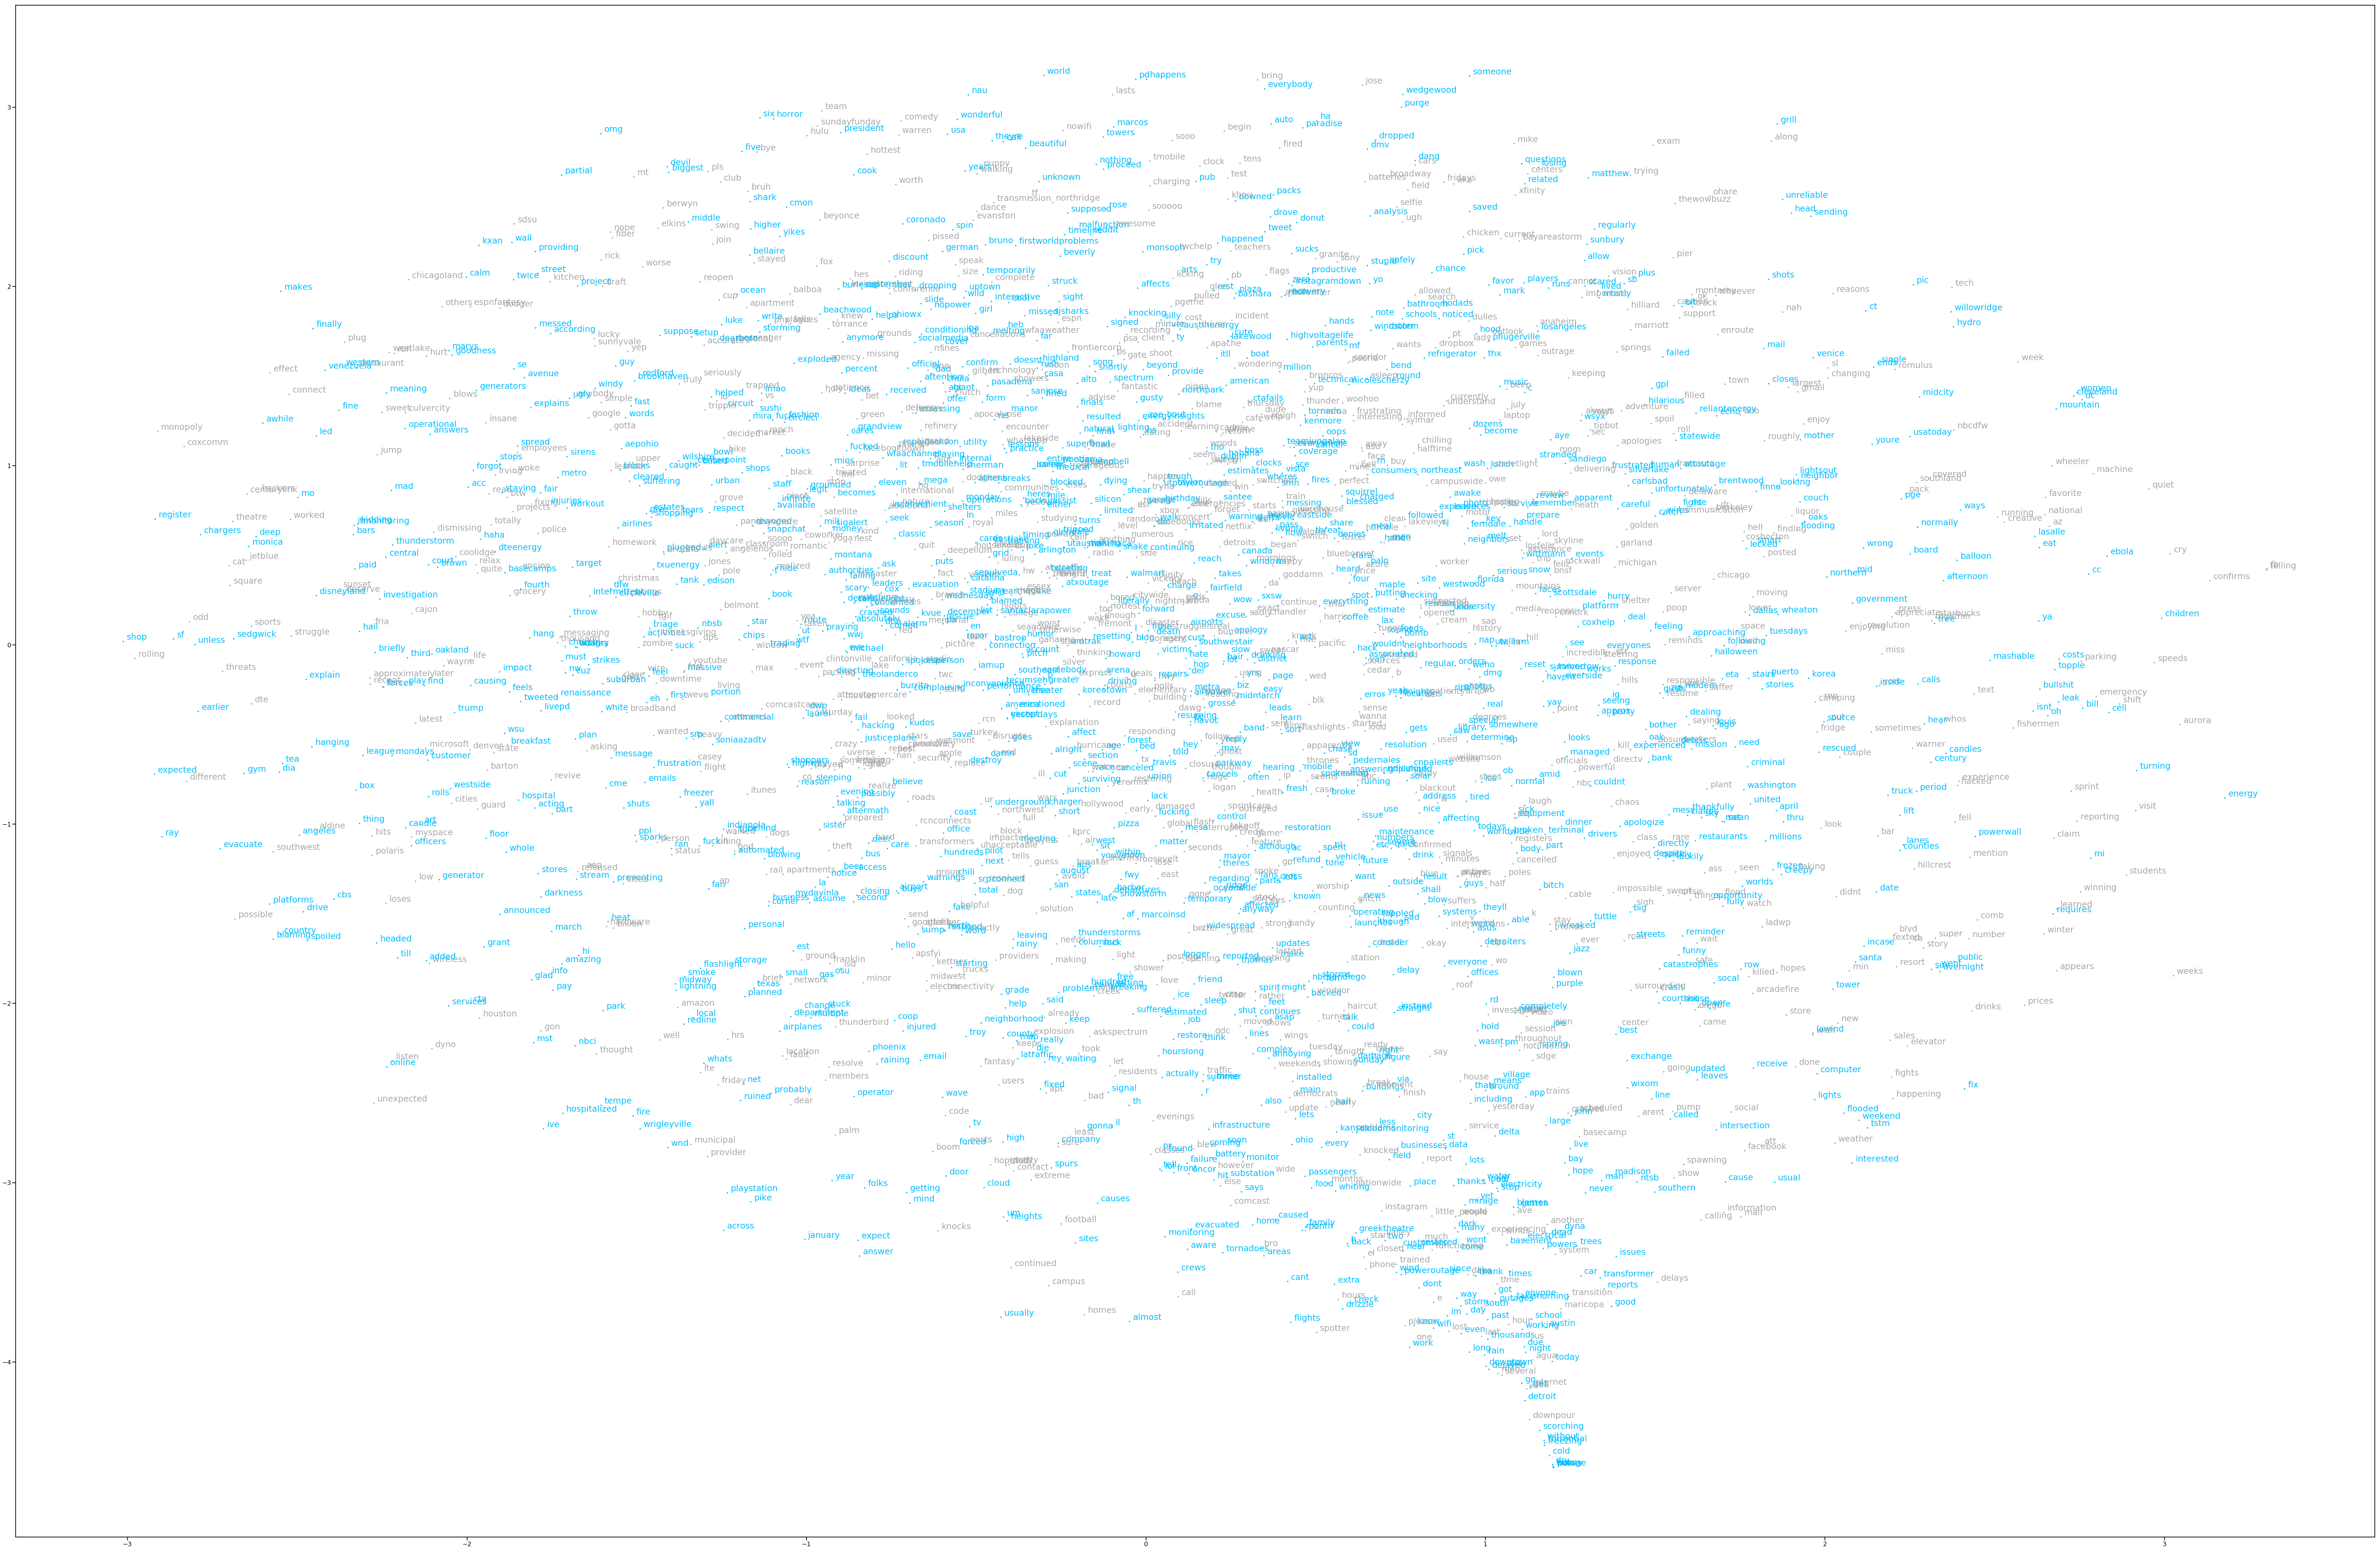

In [39]:
#plotting the t-SNE
plt.figure(figsize = (150,100))
colors = {'power_out':'deepskyblue', 'not_out':'darkgrey'}
for i,word in enumerate(points['word']):
    x = points['x'][i]
    y = points['y'][i]
    color = points['power_out_label'].apply(lambda x: colors[x])[i]
    plt.scatter(x, y, color=color, s = 10)
    plt.text(x+0.01, y+0.01, word,color = color, fontsize=30)
plt.show()

# to see the plot please zoom in. 

## Exporting Visual

This code will create and export an html file that will allow you to interact with the visual plot. The dots in blue represent the power being out, while gray dots are associated with it not being a legitimate power outage. The size of the dot also shows us how high it’s cosine similarity score is. Larger dots have larger scores, meaning a stronger relationship to either the positive or negative word list.

In [41]:
#creating and exporting an html file of the t-SNE plot

import numpy as np

from bokeh.plotting import figure, show, output_file,ColumnDataSource

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

source = ColumnDataSource(data = dict(
    x = points['x'],
    y = points['y'],
    label = points['power_out_label'],
    power_out_cs = points['power_out_cs'],
    not_out_cs = points['not_out_cs'],
    radii = ((points['power_out_cs']*points['power_out_label'].apply(lambda x: 1 if (x == 'power_out') else 0))+(points['not_out_cs']*points['power_out_label'].apply(lambda x: 0 if (x == 'power_out') else 1)))*0.25,
    color = points['power_out_label'].apply(lambda x: colors[x]),
    words = points['word']
))
TOOLTIPS =[
    ('word', '@words'),
    ('class','@label'),
    ('power out cos sim','@power_out_cs'),
    ('not out cos sim','@not_out_cs')
]
p = figure(title = 't-SNE Plot of Words in Tweets',
           tooltips=TOOLTIPS)

p.scatter('x', 'y', radius='radii', source = source,
          fill_color='color', line_color = None, fill_alpha=0.3)

output_file("./visualizations/tsne_scatter.html", title="tsne_scatter.py")

show(p)  # open a browser

## Evaluation

To evaluate our model’s performance, we had to manually confirm whether or not it was classified correctly. Ideally, we’d be able to go through all the tweets to confirm this but we ran out of time. We reviewed one thousand tweets and found six misclassifications. We’d need to review more to confirm whether this is what to expect in terms of number of misclassifications or an anomaly. From there we’d need to fine tune the model to lessen misclassifications. 

When we started this process, we believed that weather played a large role in power outages, and it does. However, we also discovered that the word “snakes” related high for flagging legitimate power outages. And that’s how we learned that snakes can climb into transformers and cause power outages. 

**Please continue to [3_Outage_Map_and_Next_Steps.ipynb](./3_Outage_Map_and_Next_Steps.ipynb) for the next step in the project: Outage Map**